In [ ]:
# default_exp dl_101

In [ ]:
#hide
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    !pip install -Uqq git+https://github.com/stardust-r/walk-with-deep-learning.git
    !pip install -Uqq fastai nbdev

# Deep learning 101 with Pytorch and fastai

> Some code and text snippets have been extracted from the book [\"Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD\"](https://course.fast.ai/), and from these blog posts [[ref1](https://muellerzr.github.io/fastblog/2021/02/14/Pytorchtofastai.html)].

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.all import *
import wandb

In [ ]:
# export
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch.nn as nn
from wwdl.utils import *

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

## Linear regression model in Pytorch

### Datasets and Dataloaders

We'll create a dataset that contains $(x,y)$ pairs sampled from the linear function $y = ax + b+ \epsilon$. To do this, we'll create a PyTorch's `TensorDataset`.

A PyTorch tensor is nearly the same thing as a NumPy array. The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. These two things are critical for deep learning

In [ ]:
# export
def linear_function_dataset(a, b, n=100, show_plot=False):
    r"""
        Creates a Pytorch's `TensorDataset` with `n` random samples of the 
        linear function y = `a`*x + `b`. `show_plot` dcides whether or not to 
        plot the dataset
    """
    x = torch.randn(n, 1)
    y = a*x + b + 0.1*torch.randn(n, 1)
    if show_plot:
        show_TensorFunction1D(x, y, marker='.')
    return TensorDataset(x, y)

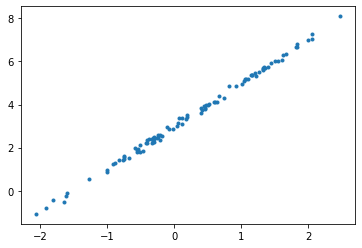

In [ ]:
a = 2
b = 3
n = 100
data = linear_function_dataset(a, b, n, show_plot=True)
test_eq(type(data), TensorDataset)

In every machine/deep learning experiment, we need to have at least two datasets:
 - training: used to train the model
 - validation: used to validate the model after each training step. It allows to detect overfitting and adjust the hyperparameters of the model properly

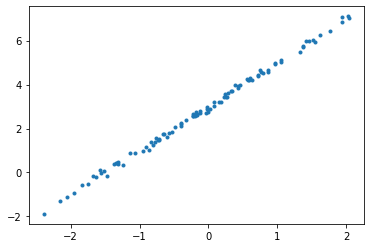

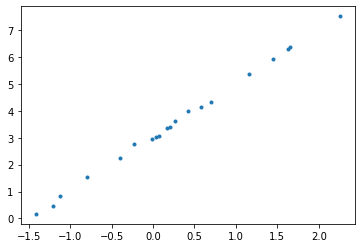

In [ ]:
train_ds = linear_function_dataset(a, b, n=100, show_plot=True)
valid_ds = linear_function_dataset(a, b, n=20, show_plot=True)

A dataloader combines a dataset an a sampler that samples data into **batches**, and provides an iterable over the given dataset. 

In [ ]:
bs = 10
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, shuffle=False)

In [ ]:
for i, data in enumerate(train_dl, 1):
    x, y = data
    print(f'batch {i}: x={x.shape} ({x.device}), y={y.shape} ({y.device})')

batch 1: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 2: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 3: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 4: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 5: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 6: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 7: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 8: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 9: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 10: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)


### Defining a linear regression model in Pytorch

The class `torch.nn.Module` is the base structure for all models in Pytorch. It mostly helps to register all the trainable parameters. A module is an object of a class that inherits from the PyTorch `nn.Module` class.

To implement an `nn.Module` you just need to:

- Make sure the superclass __init__ is called first when you initialize it.
- Define any parameters of the model as attributes with nn.Parameter. To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` class. All PyTorch modules use `nn.Parameter` for any trainable parameters. This class doesn't actually add any functionality (other than automatically calling `requires_grad`). It's only used as a "marker" to show what to include in parameters:
- Define a forward function that returns the output of your model.

In [ ]:
#export
class LinRegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        
    def forward(self, x): return self.a*x + self.b

In [ ]:
model = LinRegModel()
pa, pb = model.parameters()
pa, pa.shape, pb, pb.shape

(Parameter containing:
 tensor([0.8746], requires_grad=True),
 torch.Size([1]),
 Parameter containing:
 tensor([-0.1284], requires_grad=True),
 torch.Size([1]))

Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

In [ ]:
x = torch.randn(10, 1)
out = model(x)
x, x.shape, out, out.shape 

(tensor([[ 0.2781],
         [-1.1728],
         [-2.0544],
         [ 1.3441],
         [ 1.2472],
         [-0.5882],
         [-1.2542],
         [-1.0568],
         [-0.0352],
         [-1.0254]]),
 torch.Size([10, 1]),
 tensor([[ 0.1148],
         [-1.1540],
         [-1.9251],
         [ 1.0472],
         [ 0.9624],
         [-0.6428],
         [-1.2252],
         [-1.0526],
         [-0.1591],
         [-1.0251]], grad_fn=<AddBackward0>),
 torch.Size([10, 1]))

### Loss function and optimizer

The loss is the thing the machine is using as the measure of performance to decide how to update model parameters. The loss function is simple enough for a regression problem, we'll just use the Mean Square Error (MSE)

In [ ]:
loss_func = nn.MSELoss()
loss_func(x, out)

tensor(0.0232, grad_fn=<MseLossBackward>)

We have data, a model, and a loss function; we only need one more thing we can fit a model, and that's an optimizer.

In [ ]:
opt_func = torch.optim.SGD(model.parameters(), lr = 1e-3)

### Training loop

During training, we need to push our model and our batches to the GPU. Calling `cuda()` on a model or a tensor this class puts all these parameters on the GPU:

In [ ]:
model = model.to(device)

To train a model, we will need to compute all the gradients of a given loss with respect to its parameters, which is known as the *backward pass*. The *forward pass* is where we compute the output of the model on a given input, based on the matrix products. PyTorch computes all the gradients we need with a magic call to `loss.backward`. The backward pass is the chain rule applied multiple times, computing the gradients from the output of our model and going back, one layer at a time. 

In Pytorch, Each basic function we need to differentiate is written as a `torch.autograd.Function` object that has a `forward` and a `backward` method. PyTorch will then keep trace of any computation we do to be able to properly run the backward pass, unless we set the `requires_grad` attribute of our tensors to `False`. 

For minibatch gradient descent (the usual way of training in deep learning), we calculate gradients on batches. Before moving onto the next batch, we modify our model's parameters based on the gradients. For each iteration through our dataset (which would be called an **epoch**), the optimizer would perform as many updates as we have batches.

There are two important methods in a Pytorch optimizer:
- `zero_grad`: In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. `zero_grad` just loops through the parameters of the model and sets the gradients to zero. It also calls `detach_`, which removes any history of gradient computation, since it won't be needed after `zero_grad`.

In [ ]:
n_epochs = 10

In [ ]:
# export
def train(model, device, train_dl, loss_func, opt_func, epoch_idx):
    r"""
        Train `model` for one epoch, whose index is given in `epoch_idx`. The 
        training loop will iterate through all the batches of `train_dl`, using
        the the loss function given in `loss_func` and the optimizer given in `opt_func`
    """
    running_loss = 0.0
    batches_processed = 0
    for batch_idx, (x, y) in enumerate(train_dl, 1):
        x, y = x.to(device), y.to(device) # Push data to GPU

        opt_func.zero_grad() # Reset gradients
        # Forward pass
        output = model(x)
        loss = loss_func(output, y)
        # Backward pass
        loss.backward()
        # Optimizer step
        opt_func.step()

        # print statistics
        running_loss += loss.item()
        batches_processed += 1
    print(f'Train loss [Epoch {epoch_idx}]: {running_loss/batches_processed : .2f})')

In [ ]:
for epoch in range(1, n_epochs+1):
    train(model, device, train_dl, loss_func, opt_func, epoch)

Train loss [Epoch 1]:  0.24)
Train loss [Epoch 2]:  0.23)
Train loss [Epoch 3]:  0.22)
Train loss [Epoch 4]:  0.21)
Train loss [Epoch 5]:  0.21)
Train loss [Epoch 6]:  0.20)
Train loss [Epoch 7]:  0.19)
Train loss [Epoch 8]:  0.18)
Train loss [Epoch 9]:  0.18)
Train loss [Epoch 10]:  0.17)


We can see how the parameters of the regression model are getting closer to the truth values `a` and `b` from the linear function.

In [ ]:
L(model.named_parameters())

(#2) [('a', Parameter containing:
tensor([1.8305], device='cuda:0', requires_grad=True)),('b', Parameter containing:
tensor([2.6229], device='cuda:0', requires_grad=True))]

### Validating the model

Validating the model requires only a forward pass, it's just inference. Disabling gradient calculation with the method `torch.no_grad()` is useful for inference, when you are sure that you will not call :meth:`Tensor.backward()`. 

In [ ]:
#export
def validate(model, device, dl):
    running_loss = 0.
    total_batches = 0
    with torch.no_grad():
        for x, y in valid_dl:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_func(output, y)
            running_loss += loss.item()
            total_batches += 1

    print(f'Valid loss: {running_loss/total_batches : .2f}')

In [ ]:
validate(model, device, valid_dl)

Valid loss:  0.24


In order to spot overfitting, it is useful to validate the model after each training epoch. 

In [ ]:
for epoch in range(1, n_epochs +1):
    train(model, device, train_dl, loss_func, opt_func, epoch)
    validate(model, device, valid_dl)

Train loss [Epoch 1]:  0.17)
Valid loss:  0.23
Train loss [Epoch 2]:  0.16)
Valid loss:  0.22
Train loss [Epoch 3]:  0.15)
Valid loss:  0.21
Train loss [Epoch 4]:  0.15)
Valid loss:  0.21
Train loss [Epoch 5]:  0.14)
Valid loss:  0.20
Train loss [Epoch 6]:  0.14)
Valid loss:  0.19
Train loss [Epoch 7]:  0.13)
Valid loss:  0.19
Train loss [Epoch 8]:  0.13)
Valid loss:  0.18
Train loss [Epoch 9]:  0.13)
Valid loss:  0.17
Train loss [Epoch 10]:  0.12)
Valid loss:  0.17


## Abstracting the manual training loop: moving from Pytorch to fastai

In [ ]:
from fastai.basics import *
from fastai.callback.progress import ProgressCallback

We can entirely replace the custom training loop with fastai's. That means you can get rid of `train()`, `validate()`, and the epoch loop in the original code, and replace it all with a couple of lines.

fastai's training loop lives in a `Learner`. The Learner is the glue that merges everything together (Datasets, Dataloaders, model and optimizer) and enables to train by just calling a `fit` function.

fastai's `Learner` expects DataLoaders to be used, rather than simply one DataLoader, so let's make that. We could just do `dls = Dataloaders(train_dl, valid_dl)`, to keep the PyTorch Dataloaders. However, by using a fastai `DataLoader` instead, created directly from the `TensorDataset` objects, we have some automations, such as automatic pushing of the data to GPU. 

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=10)

In [ ]:
learn = Learner(dls, model=LinRegModel(), loss_func=nn.MSELoss(), opt_func=SGD)

Now we have everything needed to do a basic `fit`:

In [ ]:
learn.fit(10, lr=1e-3)

epoch,train_loss,valid_loss,time
0,4.409783,5.623891,00:00
1,4.330524,5.417769,00:00
2,4.249581,5.219263,00:00
3,4.158011,5.028091,00:00
4,4.062205,4.843980,00:00
5,3.951461,4.666675,00:00
6,3.847290,4.495928,00:00
7,3.749627,4.331471,00:00
8,3.643744,4.173088,00:00
9,3.542854,4.020545,00:00


Having a Learner allows us to easily gather the model predictions for the validation set, which we can use for visualisation and analysis

In [ ]:
inputs, preds, outputs = learn.get_preds(with_input=True)
inputs.shape, preds.shape, outputs.shape

(torch.Size([20, 1]), torch.Size([20, 1]), torch.Size([20, 1]))

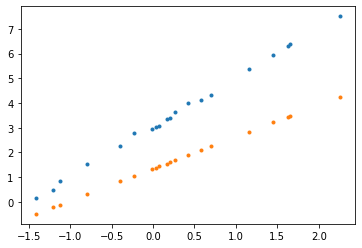

In [ ]:
show_TensorFunction1D(inputs, outputs, y_hat=preds, marker='.')

## Building a simple neural network

For the next example, we will create the dataset by sampling values from a non linear sample $y(x) = -\frac{1}{100}x^7 - x^4 - 2x^2 - 4x + 1$

In [ ]:
# Single config object, useful for experiment tracking
config = dict(
    ntrain = 1000,
    nvalid = 200,
    nh1 = 200,
    nh2 = 100,
    nh3 = 50
)

In [ ]:
run = wandb.init(config=config, project="TS-III", anonymous='allow')

wandb: Currently logged in as: vrodriguezf (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
# export
def nonlinear_function_dataset(n=100, show_plot=False):
    r"""
        Creates a Pytorch's `TensorDataset` with `n` random samples of the 
        nonlinear function y = (-1/100)*x**7 -x**4 -2*x**2 -4*x + 1 with a bit 
        of noise. `show_plot` decides whether or not to plot the dataset
    """
    x = torch.rand(n, 1)*20 - 10 # Random values between [-10 and 10]
    y = (-1/100)*x**7 -x**4 -2*x**2 -4*x + 1 + 0.1*torch.randn(n, 1)
    if show_plot:
        show_TensorFunction1D(x, y, marker='.')
    return TensorDataset(x, y)

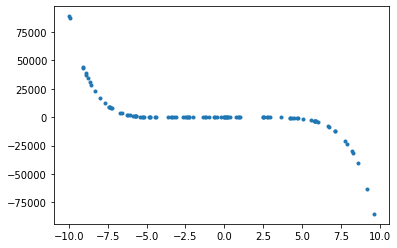

In [ ]:
n = 100
ds = nonlinear_function_dataset(n, show_plot=True)
x, y = ds.tensors
test_eq(x.shape, y.shape)

We will create the trainin and test dataset, and build the Dataloaders with them, this time directly in fastai, using the `Dataloaders.from_dsets` method.

In [ ]:
train_ds = nonlinear_function_dataset(n=1000)
valid_ds = nonlinear_function_dataset(n=200)

Normalization in deep learning are used to make optimization easier by smoothing the loss surface of the network. We will normalize the data based on the mean and std of the train dataset

In [ ]:
norm_mean = train_ds.tensors[1].mean()
norm_std = train_ds.tensors[1].std()

In [ ]:
train_ds_norm = TensorDataset(train_ds.tensors[0],
                              (train_ds.tensors[1] - norm_mean)/norm_std)
valid_ds_norm = TensorDataset(valid_ds.tensors[0],
                              (valid_ds.tensors[1] - norm_mean)/norm_std)

In [ ]:
dls = DataLoaders.from_dsets(train_ds_norm, valid_ds_norm, bs = 32)

We will build a Multi Layer Perceptron with 3 hidden layers. These networks are also known as Feed-Forward Neural Networks. The layers aof this type of networks are known as Fully Connected Layers, because, between every subsequent pair of layers, all the neurons are connected to each other.

<img alt="Neural network architecture" caption="Neural network" src="https://i.imgur.com/5ZWPtRS.png">

The easiest way of wrapping several layers in Pytorch is using the `nn.Sequential` module. It creates a module with a `forward` method that will call each of the listed layers or functions in turn, without us having to do the loop manually in the forward pass.

In [ ]:
#export
class MLP3(nn.Module):
    r"""
        Multilayer perceptron with 3 hidden layers, with sizes `nh1`, `nh2` and
        `nh3` respectively.
    """
    def __init__(self, n_in=1, nh1=200, nh2=100, nh3=50, n_out=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_in, nh1),
            nn.ReLU(), 
            nn.Linear(nh1, nh2),
            nn.ReLU(),
            nn.Linear(nh2, nh3),
            nn.ReLU(),
            nn.Linear(nh3, n_out)
        )
        
    def forward(self, x): return self.layers(x)

In [ ]:
x, y = dls.one_batch()
model = MLP3()
output = model(x)
output.shape

torch.Size([32, 1])

In order to have automatic logging of training parameters with Weights & Biases, we add the callback `WandbCallback` to the call to `fit`. This process would be similar in any other framework we use to train a neural network (e.g., Keras)

In [ ]:
from fastai.callback.wandb import *

In [ ]:
learn = Learner(dls, MLP3(), loss_func=nn.MSELoss(), opt_func=Adam, 
                cbs=[WandbCallback()])

In [ ]:
learn.fit(10, lr=1e-3)

WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,time
0,0.480955,0.507817,00:01
1,0.409459,0.467532,00:00
2,0.363784,0.331932,00:00
3,0.314855,0.338062,00:00
4,0.270671,0.281873,00:00
5,0.216957,0.259713,00:00
6,0.180112,0.175947,00:00
7,0.160715,0.174258,00:00
8,0.130713,0.112270,00:01
9,0.108655,0.076387,00:00


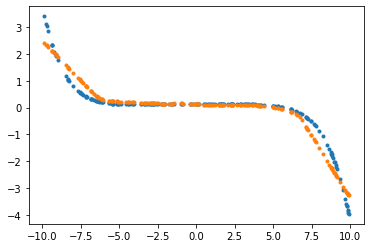

In [ ]:
inputs, preds, outputs = learn.get_preds(with_input = True)
show_TensorFunction1D(inputs, outputs, y_hat=preds, marker='.')

Once we have finised training our model of interest, we can close the experiment tracker (Weights & Biases)

In [ ]:
run.finish()

epoch,10
train_loss,0.10866
raw_loss,0.08678
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.001
mom_0,0.9
eps_0,1e-05
_runtime,425
_timestamp,1615802106
_step,309


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
raw_loss,▆▃▅█▄▄▆▆▆▂█▅▂▂▄▅▄▅▂▁▅▂▂▁▂▄▃▂▂▁▄▂▂▂▁▁▁▂▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Let's compare these results with the ones by our previous linear regression model

In [ ]:
learn_lin = Learner(dls, LinRegModel(), loss_func=nn.MSELoss(), opt_func=Adam)

In [ ]:
learn_lin.fit(20, lr=1e-3)

epoch,train_loss,valid_loss,time
0,4.630294,5.063892,00:00
1,4.435525,4.612046,00:00
2,4.177605,4.230232,00:00
3,3.886681,3.899921,00:00
4,3.648355,3.629560,00:00
5,3.402417,3.395575,00:00
6,3.191740,3.205456,00:00
7,3.011224,3.047209,00:00
8,2.864215,2.908578,00:00
9,2.725510,2.785707,00:00


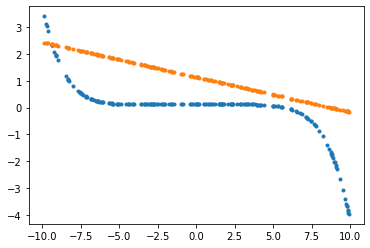

In [ ]:
inputs, preds, outputs = learn_lin.get_preds(with_input = True)
show_TensorFunction1D(inputs, outputs, y_hat=preds, marker='.')

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_dl_101_pytorch_fastai.ipynb.
Converted index.ipynb.
Converted utils.ipynb.
